In [290]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [291]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [292]:
# data for multiclass
NUM_SAMPLES = 1000 # number of samples
NUM_CLASSES = 4 # number of classess in data
NUM_FEATURES = 2 # number of features to represent each data point
RANDOM_SEED = 32


In [293]:
# make blobs for multi class data
def make_blobs_data(n_samples=NUM_SAMPLES, n_class=NUM_CLASSES, n_features=NUM_FEATURES, std_dev=1.5, random_seed=RANDOM_SEED):
    X_blob, y_blob = make_blobs(n_samples=NUM_SAMPLES,
                                                    centers=NUM_CLASSES,
                                                    cluster_std= std_dev,
                                                    random_state=RANDOM_SEED)
    return X_blob, y_blob

In [294]:
# convert data into torch
X_blob, y_blob = make_blobs_data()
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.long)

# split into train and test

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

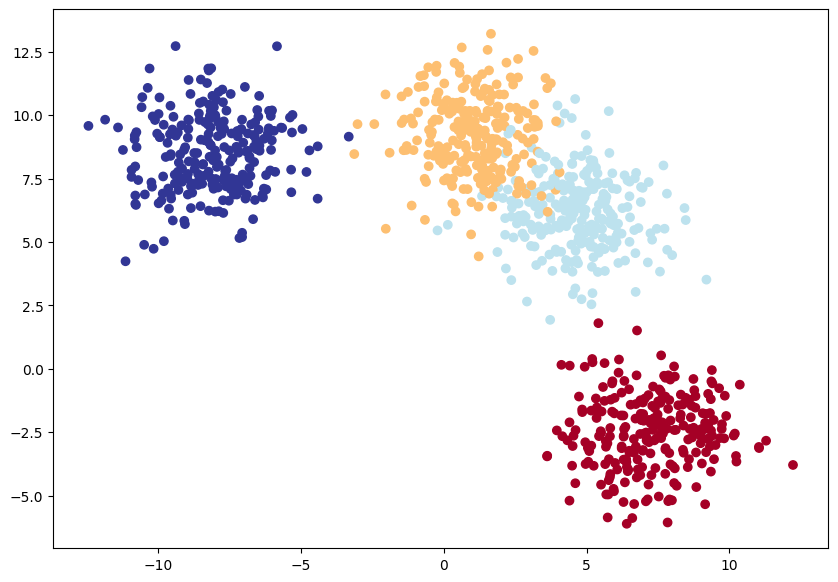

In [295]:
# visualize the data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [296]:
# sett up device
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

In [297]:
### multi class classification model
class BlobModel(nn.Module):
    # set random state
   # torch.manual_seed(32)
    def __init__(self, input_features, output_features, hidden_units=8):

        """
        initializes multiclass classification model
        args:
            - input_features (int): number of input features for the model
            - output_features (int): number of output features or number of classess that the model gives
            - hidden_units (int): number of hidden units between layers


        """
        super(BlobModel, self).__init__()

        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )


    def forward(self, x):
        return self.linear_layer_stack(x)


In [298]:
# calculate accuracy : what percentage does the model get right
def accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return (correct/len(y_pred)) * 100


In [299]:
# instance of blob model
blob_model_v1 = BlobModel(input_features=2, output_features=4, hidden_units=32).to(device)

blob_model_v1

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=4, bias=True)
  )
)

In [300]:
# loss function
criterion = nn.CrossEntropyLoss()

# optimization
optimizer = optim.SGD(params=blob_model_v1.parameters(), lr=0.01)

In [301]:
before_training_predictions = blob_model_v1(X_blob_train)
blob_model_v1.eval()
with torch.inference_mode():
    y_logits = blob_model_v1(X_blob_test.to(device))
    y_pred_probs = torch.softmax(y_logits, dim=1)

    # convert prediction probabilities to prediction labels
    y_predictions = torch.argmax(y_pred_probs, dim=1)


print(y_logits[:5])
print(y_pred_probs[:5])
print(y_predictions)


tensor([[-0.6303,  0.0024,  0.0808,  0.5683],
        [-0.4812, -0.1389,  0.0309,  0.3992],
        [-0.6327, -0.2129,  0.0691,  0.4582],
        [-0.1389,  0.2227,  0.2888,  1.3081],
        [ 0.3024, -0.3739, -0.0776,  1.0132]])
tensor([[0.1214, 0.2286, 0.2473, 0.4027],
        [0.1541, 0.2170, 0.2572, 0.3717],
        [0.1331, 0.2025, 0.2684, 0.3961],
        [0.1217, 0.1747, 0.1866, 0.5171],
        [0.2365, 0.1203, 0.1617, 0.4815]])
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

In [302]:
torch.manual_seed(32)
torch.cuda.manual_seed(32)

num_epochs = 100 # training and testing loop

#X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
#X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_train.to(device)

for epoch in range(num_epochs):

    blob_model_v1.train()
    optimizer.zero_grad()
    y_train_logits = blob_model_v1(X_blob_train)
    y__train_preds = torch.softmax(y_train_logits, dim=1).argmax(dim=1)

    loss = criterion(y_train_logits, y_blob_train)
    acc = accuracy(y_true=y_blob_train, y_pred=y__train_preds)

    loss.backward()
    optimizer.step()

    # testing
    blob_model_v1.eval()

    with torch.inference_mode():
        test_logits = blob_model_v1(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = criterion(test_logits, y_blob_test)
        test_accuracy = accuracy(y_true=y_blob_test, y_pred=test_preds)

        if epoch % 10 == 0:
            print(f'Epoch: {epoch}, Loss: {loss:.4f}, Acc: {acc:.2f}, Test Loss: {test_loss:.4f}, Test acc: {test_accuracy:.4f}')


Epoch: 0, Loss: 1.4442, Acc: 23.50, Test Loss: 1.3013, Test acc: 31.0000
Epoch: 10, Loss: 0.9369, Acc: 63.62, Test Loss: 0.9070, Test acc: 65.0000
Epoch: 20, Loss: 0.7673, Acc: 71.62, Test Loss: 0.7523, Test acc: 67.5000
Epoch: 30, Loss: 0.6583, Acc: 78.25, Test Loss: 0.6489, Test acc: 75.5000
Epoch: 40, Loss: 0.5717, Acc: 88.75, Test Loss: 0.5667, Test acc: 88.0000
Epoch: 50, Loss: 0.4990, Acc: 93.12, Test Loss: 0.4965, Test acc: 92.5000
Epoch: 60, Loss: 0.4370, Acc: 95.00, Test Loss: 0.4359, Test acc: 94.5000
Epoch: 70, Loss: 0.3848, Acc: 96.25, Test Loss: 0.3841, Test acc: 95.0000
Epoch: 80, Loss: 0.3412, Acc: 96.75, Test Loss: 0.3402, Test acc: 96.0000
Epoch: 90, Loss: 0.3049, Acc: 97.12, Test Loss: 0.3035, Test acc: 96.5000


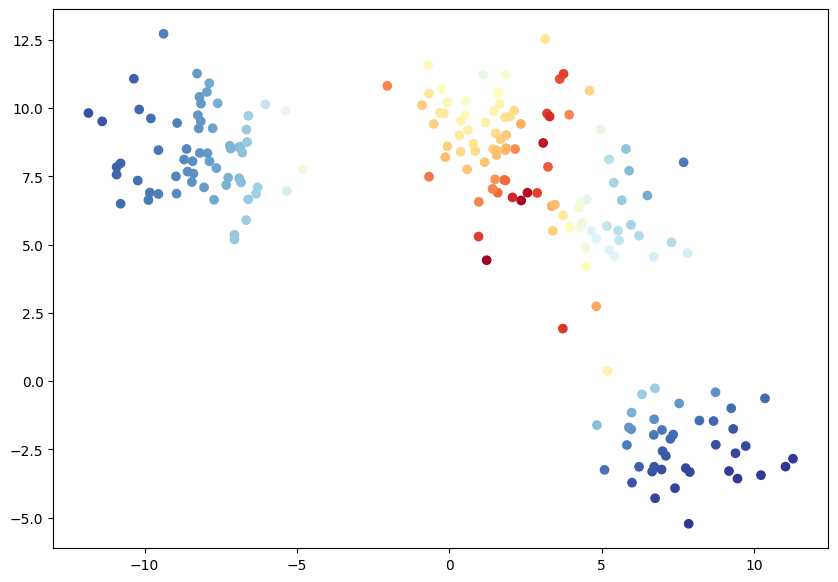

In [306]:
with torch.inference_mode():
    test_logits_map = blob_model_v1(X_blob_test)
    # test_preds_map = torch.softmax(test_logits, dim=1).argmax(dim=1) # this line is not needed
    # Apply softmax to get probabilities which will be in range 0-1
    test_probs_map = torch.softmax(test_logits_map, dim=1)

# visualize the data
plt.figure(figsize=(10, 7))
# Use the probabilities for color mapping instead of raw logits
plt.scatter(X_blob_test[:, 0], X_blob_test[:, 1], c=test_probs_map.max(dim=1).values, cmap=plt.cm.RdYlBu)